In [38]:
print('setup working')

setup working


In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


In [40]:
#read csv 
df = pd.read_csv('orders.csv', delimiter=";")
print(df.head())

         Order ID   Segment    Ship Mode   Value
0  CA-2011-103366  Consumer  First Class  149,95
1  CA-2011-109043  Consumer  First Class   243,6
2  CA-2011-113166  Consumer  First Class   9,568
3  CA-2011-124023  Consumer  First Class    8,96
4  CA-2011-130155  Consumer  First Class    34,2


In [41]:
df_cleaned = df.copy()

In [42]:
#count 
print(df_cleaned['Segment'].value_counts())
print(df_cleaned['Ship Mode'].value_counts())



Segment
Consumer       73
Corporate      41
Home Office    13
Name: count, dtype: int64
Ship Mode
Standard Class    498
Second Class      167
First Class       127
Same Day           42
Name: count, dtype: int64


In [43]:
# remove white spaces from column names (do not overwrite df_cleaned)
# previously df_cleaned = df.columns.str.strip() set df_cleaned to an Index; fix by modifying columns

df_cleaned.columns = df_cleaned.columns.str.strip()

In [44]:
df_cleaned.head()

,Order ID,Segment,Ship Mode,Value
0,CA-2011-103366,Consumer,First Class,"149,95"
1,CA-2011-109043,Consumer,First Class,"243,6"
2,CA-2011-113166,Consumer,First Class,"9,568"
3,CA-2011-124023,Consumer,First Class,"8,96"
4,CA-2011-130155,Consumer,First Class,"34,2"


In [45]:
#check shape and info
df_cleaned.shape
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Order ID   834 non-null    object
 1   Segment    127 non-null    object
 2   Ship Mode  834 non-null    object
 3   Value      834 non-null    object
dtypes: object(4)
memory usage: 26.2+ KB


In [46]:
#check stats
df_cleaned.describe()

,Order ID,Segment,Ship Mode,Value
count,834,127,834,834
unique,823,3,4,810
top,Grand Total,Consumer,Standard Class,"15,552"
freq,12,73,498,4


In [47]:
df_cleaned['Value'].isnull().sum()


np.int64(0)

In [48]:
# rename Ship Mode column in df_cleaned (operate on df_cleaned, not df)

df_cleaned.rename(columns={'Ship Mode': 'Ship_Mode'}, inplace=True)


In [49]:
df_cleaned['Ship_Mode'] = df_cleaned['Ship_Mode'].str.replace(" ", "_")
df_cleaned['Segment'] = df_cleaned['Segment'].str.replace(" ", "_")

In [50]:
# drop order id as it is an identifier therefore not useful for analysis
# Use inplace=True or assignment to keep it removed

df_cleaned.drop(columns=['Order ID'], inplace=True)


In [51]:
# fix value column first
# fix European-style numbers

df_cleaned['Value'] = df_cleaned['Value'].astype(str).str.replace(',', '.').str.strip()

# convert to numeric safely (use df_cleaned on RHS)
df_cleaned['Value'] = pd.to_numeric(df_cleaned['Value'], errors='coerce')


In [52]:
# subset drop value as it is the target variable; use inplace=True or assign to df_cleaned

df_cleaned.dropna(subset=['Value'], inplace=True)


In [53]:
#data cleaning
#check for missing values
missing = df_cleaned.isnull().sum().sort_values(ascending=False)
missing_perc = (df_cleaned.isnull().sum()/len(df_cleaned)*100).sort_values(ascending=False)
pd.concat([missing, missing_perc], axis=1, keys=['Missing Values', '% of Total Values']).transpose()        


,Segment,Ship_Mode,Value
Missing Values,707.000000,0.0,0.0
% of Total Values,84.772182,0.0,0.0


In [54]:
for col in ['Segment', 'Ship_Mode']:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0]).str.strip()


In [55]:
#check missing value again
df_cleaned.isnull().sum()

Segment      0
Ship_Mode    0
Value        0
dtype: int64

In [56]:
#check duplicates 
df_cleaned_duplicates = df_cleaned.duplicated().sum()
print(f'The number of duplicate rows is: {df_cleaned_duplicates}')


The number of duplicate rows is: 10


In [57]:
# remove duplicate rows; use inplace=True to actually remove them

df_cleaned.drop_duplicates(inplace=True)
print(f'The number of duplicate rows after removing duplicates is: {df_cleaned.duplicated().sum()}')
print(f'The new shape of the dataframe is: {df_cleaned.shape}')

The number of duplicate rows after removing duplicates is: 0
The new shape of the dataframe is: (824, 3)

The new shape of the dataframe is: (824, 3)


In [58]:
#change data types
df_cleaned['Segment']= df_cleaned['Segment'].astype('category')



In [59]:
df_cleaned['Ship_Mode']= df_cleaned['Ship_Mode'].astype('category')

In [60]:
#count 
print(df_cleaned['Segment'].value_counts())
print(df_cleaned['Ship_Mode'].value_counts())

Segment
Consumer       770
Corporate       41
Home_Office     13
Name: count, dtype: int64
Ship_Mode
Standard_Class    489
Second_Class      166
First_Class       127
Same_Day           42
Name: count, dtype: int64


This shows that the data is highly imbalanced 

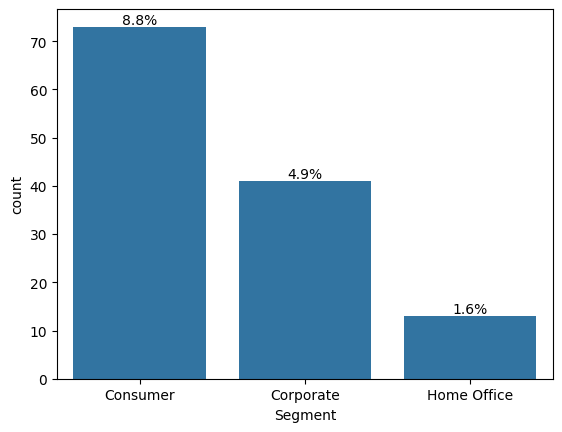

In [61]:
ax = sns.countplot(x='Segment', data=df)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/len(df):.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')
plt.show()


the visualization shows that the dataset is highly imbalanced due to the fact that i used mode as a missing data handling technique so it means we need to treat imbalances 

EDA

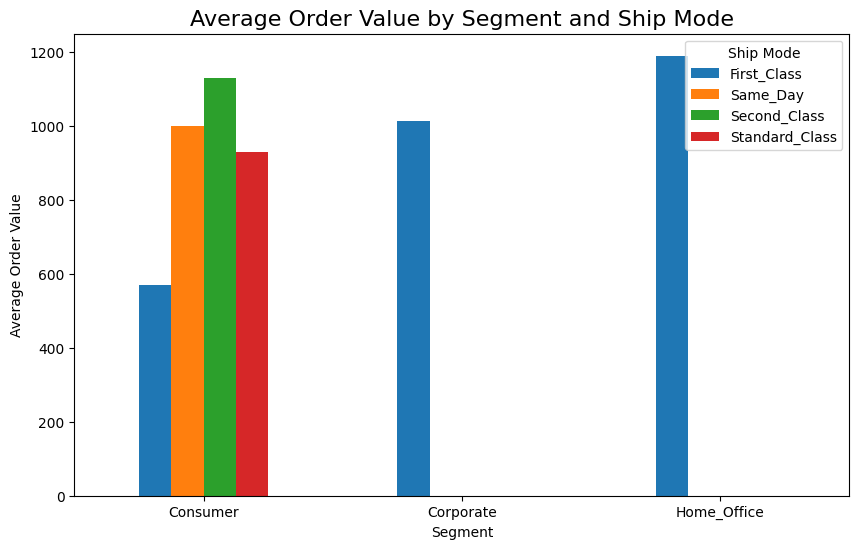

In [62]:
# calculate average order value for each segment-ship mode combination
grouped = df_cleaned.groupby(['Segment','Ship_Mode'])['Value'].mean().unstack()

# clot grouped bar chart
grouped.plot(kind='bar', figsize=(10,6))
plt.title('Average Order Value by Segment and Ship Mode', fontsize=16)
plt.ylabel('Average Order Value')
plt.xlabel('Segment')
plt.xticks(rotation=0)
plt.legend(title='Ship Mode')
plt.show()


In [63]:
#check skewness 
df_cleaned['Value'].skew()

np.float64(14.864466391351174)

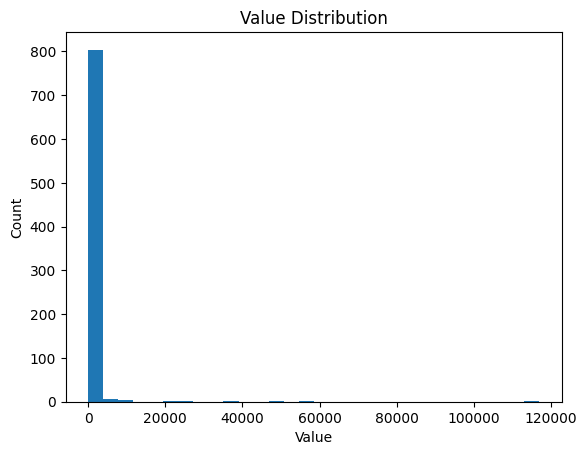

In [64]:
#visualize skewness

plt.hist(df_cleaned['Value'], bins=30)
plt.title('Value Distribution')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()


In [65]:
df_cleaned['Value_log']= np.log1p(df_cleaned['Value'])



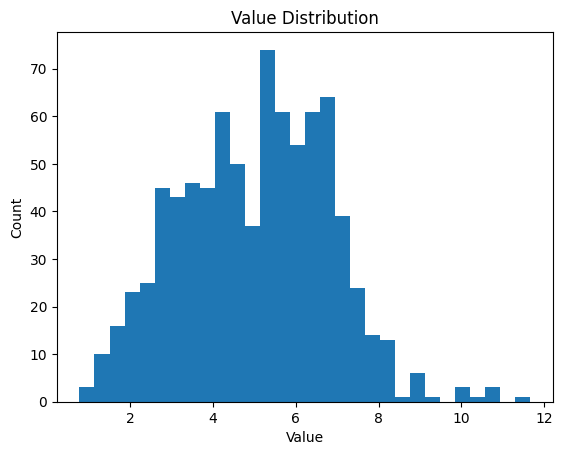

In [66]:
#visualize skewness

plt.hist(df_cleaned['Value_log'], bins=30)
plt.title('Value Distribution')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()


In [67]:
df_cleaned['Value_log']

0       5.016949
1       5.499624
2       2.357831
3       2.298577
4       3.561046
         ...    
829     6.243188
830     6.395779
831     5.005020
832     2.366874
833    10.910526
Name: Value_log, Length: 824, dtype: float64

In [68]:
df_cleaned['Value_log'].dtype

dtype('float64')

In [69]:
df_cleaned.dtypes

Segment      category
Ship_Mode    category
Value         float64
Value_log     float64
dtype: object

In [70]:
print(type(df_cleaned))
print(df_cleaned)


<class 'pandas.core.frame.DataFrame'>
      Segment       Ship_Mode       Value  Value_log
0    Consumer     First_Class    149.9500   5.016949
1    Consumer     First_Class    243.6000   5.499624
2    Consumer     First_Class      9.5680   2.357831
3    Consumer     First_Class      8.9600   2.298577
4    Consumer     First_Class     34.2000   3.561046
..        ...             ...         ...        ...
829  Consumer  Standard_Class    513.4960   6.243188
830  Consumer  Standard_Class    598.3100   6.395779
831  Consumer  Standard_Class    148.1600   5.005020
832  Consumer  Standard_Class      9.6640   2.366874
833  Consumer  Standard_Class  54748.6325  10.910526

[824 rows x 4 columns]


In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Ensure a simple baseline prediction exists. If `baseline_preds` is not defined,
# use the mean of `Value_log` as the constant prediction for every row.
try:
    baseline_preds
except NameError:
    baseline_value = df_cleaned['Value_log'].mean()
    baseline_preds = np.full(shape=len(df_cleaned['Value_log']), fill_value=baseline_value)

# Compute metrics comparing the actuals to the baseline predictions
mse = mean_squared_error(df_cleaned['Value_log'], baseline_preds)
# RMSE = sqrt(MSE)
baseline_rmse = np.sqrt(mse)
baseline_mae = mean_absolute_error(df_cleaned['Value_log'], baseline_preds)
baseline_r2 = r2_score(df_cleaned['Value_log'], baseline_preds)

print("Baseline RMSE:", baseline_rmse)
print("Baseline MAE:", baseline_mae)
print("Baseline R²:", baseline_r2)


Baseline RMSE: 1.7956334871325927
Baseline MAE: 1.4792840839074086
Baseline R²: 0.0


In [72]:
#save as csv
df_cleaned= df_cleaned.to_csv("orders_clean.csv", index=False)

In [73]:
#load new csv file
df_encode = pd.read_csv('orders_clean.csv')

In [74]:
df_encode.dtypes

Segment       object
Ship_Mode     object
Value        float64
Value_log    float64
dtype: object

In [75]:
#change datatype
df_encode['Segment'] = df_encode['Segment'].astype('category')
df_encode['Ship_Mode'] = df_encode['Ship_Mode'].astype('category')


In [76]:
df_encode.dtypes

Segment      category
Ship_Mode    category
Value         float64
Value_log     float64
dtype: object

In [77]:
# choose columns needed
X = df_encode[['Segment', 'Ship_Mode', 'Value_log']]

In [78]:
#apply onehotencoder 
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = ohe.fit_transform(X[['Segment', 'Ship_Mode']])

#create new encoded df
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(['Segment','Ship_Mode']), index=X.index)

In [79]:
# Step 4: Combine with numeric column
df_ml = pd.concat([X[['Value_log']], encoded_df], axis=1)

# Step 5: Inspect
print(df_ml.head())

   Value_log  Segment_Consumer  Segment_Corporate  Segment_Home_Office  \
0   5.016949               1.0                0.0                  0.0   
1   5.499624               1.0                0.0                  0.0   
2   2.357831               1.0                0.0                  0.0   
3   2.298577               1.0                0.0                  0.0   
4   3.561046               1.0                0.0                  0.0   

   Ship_Mode_First_Class  Ship_Mode_Same_Day  Ship_Mode_Second_Class  \
0                    1.0                 0.0                     0.0   
1                    1.0                 0.0                     0.0   
2                    1.0                 0.0                     0.0   
3                    1.0                 0.0                     0.0   
4                    1.0                 0.0                     0.0   

   Ship_Mode_Standard_Class  
0                       0.0  
1                       0.0  
2                       0.0  
3 

In [80]:
# Save df_ml to CSV
df_ml.to_csv("df_ml.csv", index=False)

Modeling

In [81]:
#read csv df_ml
df_ml= pd.read_csv('df_ml.csv')
df_ml.head()

,Value_log,Segment_Consumer,Segment_Corporate,Segment_Home_Office,Ship_Mode_First_Class,Ship_Mode_Same_Day,Ship_Mode_Second_Class,Ship_Mode_Standard_Class
0,5.016949,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,5.499624,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2.357831,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2.298577,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3.561046,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [82]:
#split the data 
# X = all features except Value_log
X = df_ml.drop(columns=['Value_log'])

# y = target column (Value_log)
y = df_ml['Value_log']


In [83]:
# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (659, 7) (659,)
Test shapes: (165, 7) (165,)


In [84]:
#scale 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)        


In [85]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Decision Tree": DecisionTreeRegressor(max_depth=3, random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

results = {"Baseline": {"RMSE": 1.79, "MAE": 1.47, "R²": 0.01}}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results[name] = {"RMSE": rmse, "MAE": mae, "R²": r2}

results_df = pd.DataFrame(results).T
print(results_df)

                       RMSE       MAE        R²
Baseline           1.790000  1.470000  0.010000
Linear Regression  2.033626  1.660188 -0.016513
Ridge Regression   2.033664  1.660339 -0.016551
Decision Tree      2.044094  1.672188 -0.027005
Random Forest      2.033771  1.660995 -0.016658
Gradient Boosting  2.033626  1.660189 -0.016514


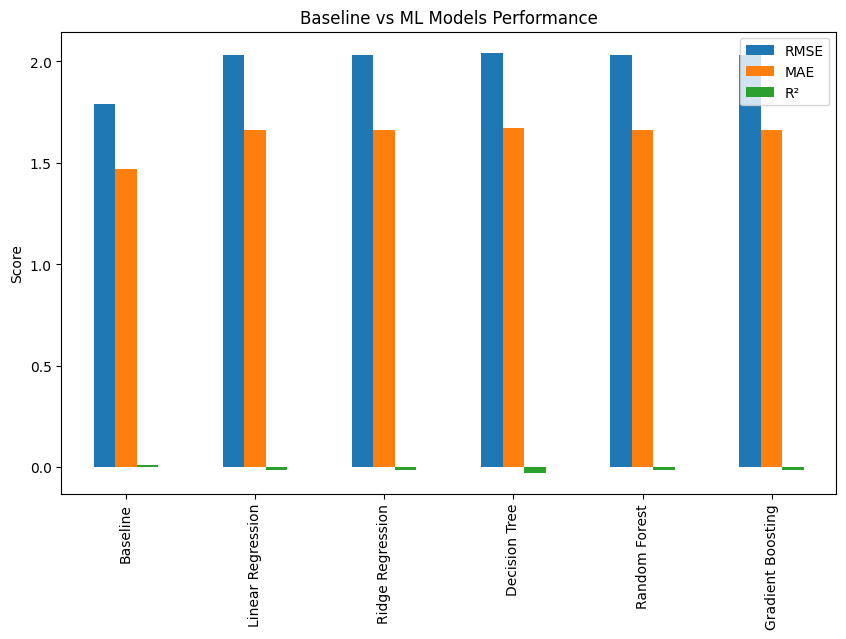

In [86]:
import matplotlib.pyplot as plt

results_df.plot(kind='bar', figsize=(10,6))
plt.title("Baseline vs ML Models Performance")
plt.ylabel("Score")
plt.show()


In [87]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features based on the already-split train/test sets
# Fit transformer on training features and transform both train and test
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

ridge_poly = Ridge(alpha=1.0)
ridge_poly.fit(X_train_poly, y_train)
preds_poly = ridge_poly.predict(X_test_poly)

rmse = np.sqrt(mean_squared_error(y_test, preds_poly))
mae = mean_absolute_error(y_test, preds_poly)
r2 = r2_score(y_test, preds_poly)
results["Ridge + PolyFeatures"] = {"RMSE": rmse, "MAE": mae, "R²": r2}

print("Original shape (features):", X.shape)
print("Expanded shape (train poly features):", X_train_poly.shape)


Original shape (features): (824, 7)
Expanded shape (train poly features): (659, 28)


In [88]:
#hyperparameter tuning 
from sklearn.model_selection import GridSearchCV
# Ridge
ridge_grid = GridSearchCV(Ridge(), {'alpha': [0.01, 0.1, 1, 10, 100]}, cv=5, scoring='r2')
ridge_grid.fit(X_train, y_train)
best_ridge = ridge_grid.best_estimator_

# Decision Tree
tree_grid = GridSearchCV(DecisionTreeRegressor(random_state=42),
                         {'max_depth': [2,3,4,5,None],
                          'min_samples_split': [2,5,10],
                          'min_samples_leaf': [1,2,5]}, cv=5, scoring='r2')
tree_grid.fit(X_train, y_train)
best_tree = tree_grid.best_estimator_

# Random Forest
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42),
                       {'n_estimators': [50,100,200],
                        'max_depth': [3,5,None],
                        'min_samples_split': [2,5],
                        'min_samples_leaf': [1,2]}, cv=5, scoring='r2')
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# Gradient Boosting
gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42),
                       {'n_estimators': [50,100,200],
                        'learning_rate': [0.01,0.1,0.2],
                        'max_depth': [2,3,4]}, cv=5, scoring='r2')
gb_grid.fit(X_train, y_train)
best_gb = gb_grid.best_estimator_

In [89]:
#final modelling
final_models = {
    "Ridge Tuned": best_ridge,
    "Decision Tree Tuned": best_tree,
    "Random Forest Tuned": best_rf,
    "Gradient Boosting Tuned": best_gb
}

for name, model in final_models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results[name] = {"RMSE": rmse, "MAE": mae, "R²": r2}


Final Comparison Table:
                             RMSE       MAE        R²
Baseline                 1.790000  1.470000  0.010000
Linear Regression        2.033626  1.660188 -0.016513
Ridge Regression         2.033664  1.660339 -0.016551
Decision Tree            2.044094  1.672188 -0.027005
Random Forest            2.033771  1.660995 -0.016658
Gradient Boosting        2.033626  1.660189 -0.016514
Ridge + PolyFeatures     2.033606  1.660208 -0.016494
Ridge Tuned              2.032579  1.660201 -0.015467
Decision Tree Tuned      2.033626  1.660188 -0.016513
Random Forest Tuned      2.032888  1.659741 -0.015775
Gradient Boosting Tuned  2.028765  1.655727 -0.011659


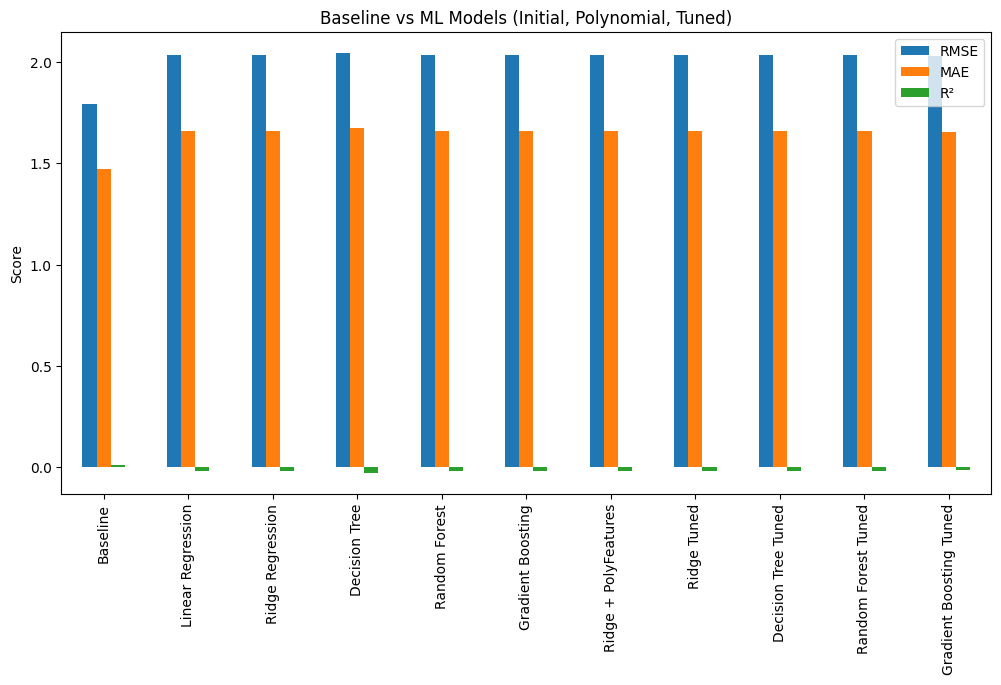

In [90]:
#
results_df = pd.DataFrame(results).T
print("\nFinal Comparison Table:")
print(results_df)

results_df.plot(kind='bar', figsize=(12,6))
plt.title("Baseline vs ML Models (Initial, Polynomial, Tuned)")
plt.ylabel("Score")
plt.show()